In [1]:
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
from IPython.display import SVG, display
import svgwrite 
import PIL
from PIL import Image
import matplotlib.pyplot as plt
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)
from train5_2_test import * 
from model5_2_R_C import *
from utils import *
from rnn import *
from sklearn import preprocessing

from ThinPlateSpline2 import ThinPlateSpline2 as stn
import re

data_dir = '../newFaceAlignment/data_new/output_npy/'
model_dir = 'parameters_5_2_bs64/'
[source_set, target_set, source_test_set, target_test_set, model_params, eval_model_params, sample_model_params] = load_env(data_dir, model_dir)
# 搭建Seq2Seq网络结构
reset_graph()
model = Model(model_params)
eval_model = Model(eval_model_params, reuse=True)
sample_model = Model(sample_model_params, reuse=True)
# 加载模型
# 设置按需使用GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config = config)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
load_checkpoint(sess, model_dir)
def adjust_temp(pi_pdf, temp):
    pi_pdf = np.log(pi_pdf) / temp
    pi_pdf -= pi_pdf.max()
    pi_pdf = np.exp(pi_pdf)
    pi_pdf /= pi_pdf.sum()
    return pi_pdf

def get_pi_idx(x, pdf, temp=1.0, greedy=False):
    if greedy:
        return np.argmax(pdf)
    pdf = adjust_temp(np.copy(pdf), temp)
    accumulate = 0
    for i in range(0, pdf.size):
        accumulate += pdf[i]
        if accumulate >= x:
            return i
    tf.logging.info('Error with sampling ensemble.')
    return -1

def sample_gaussian_2d(mu1, mu2, s1, s2, rho, temp=1.0, greedy=False):
    if greedy:
        return mu1, mu2
    mean = [mu1, mu2]
    s1 *= temp * temp
    s2 *= temp * temp
    cov = [[s1 * s1, rho * s1 * s2], [rho * s1 * s2, s2 * s2]]
    x = np.random.multivariate_normal(mean, cov, 1)
    return x[0][0], x[0][1]

# 绘制函数
def draw_strokes(data, factor=0.8, svg_filename = './Result/sample.svg'):
    tf.gfile.MakeDirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in xrange(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "red"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)

        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
    return np.array(result)
def calculate_normalizing_scale_factor(input_people):
    data = []
    for j in range(68):
        data.append(input_people[j, 0])
        data.append(input_people[j, 1])
    data = np.array(data)
    return np.std(data)
    
def normalize(input_people,scale_factor):
    for i in range(68):
        input_people[i][0:2] /= scale_factor
    return input_people

#绝对坐标转换成偏移量
def start(source,target):
    x = target[0][0] - source[0][0]
    y = target[0][1] - source[0][1]
    offset = np.zeros((68, 2), dtype=np.float32) 
    for i in range(68):
        offset[i][0] = target[i][0] - x
        offset[i][1] = target[i][1] - y
    return offset

def point_dist(s):
    a1 = (s[16][0] - s[0][0]) * (s[16][0] - s[0][0])
    a2 = (s[16][1] - s[0][1]) * (s[16][1] - s[0][1])
    d1 = math.sqrt(a1 + a2)    
    return d1

#绝对坐标转换成偏移量
def zeropoint(s):
    offset = np.zeros((68, 2), dtype=np.float32) 
    for i in range(68):
        offset[i] = s[i] - s[0].copy()        
    return offset

def reback(s,s_):
    offset = np.zeros((68, 2), dtype=np.float32) 
    for i in range(68):
        offset[i] = s[i] + s_[0].copy()        
    return offset

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
INFO:tensorflow:loaddataset-开始数据处理=================================================
INFO:tensorflow:打印原始输入长度 475.
INFO:tensorflow:打印目标输入长度 475.
INFO:tensorflow:打印测试集原始输入长度 46.
INFO:tensorflow:打印测试集目标输入长度 46.
INFO:tensorflow:model_params.max_seq_len 68.
INFO:tensorflow:正式处理数据，输入网络
INFO:tensorflow:source normalizing_scale_factor is 25.0835.
INFO:tensorflow:target normalizing_scale_factor is 22.9637.
INFO:tensorflow:model-创建seq2seqmodel====================================
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:model- decoder 部分
INFO:tensorflow:model- encoder的输入
INFO:tensorflow:model- decoder的输入和标签
INFO:tensorflow:model-encoder部分
INFO:tensorflow:model- 开始高斯混合模型采样了======================================
INFO:tensorflow:model- 调用切分输出函数
INFO:tensorflow:model- 将decoder的网络输出切分成高斯混

# test data

In [ ]:
peoples = np.load('../inputData/test_50.npy')
nopeoples = np.load('../inputData/test_50_nooffeset.npy')
for j in range(50):
    sample_idx = j
    tf.logging.info('sample的第 %i 张图片',sample_idx + 1)
    inputs = peoples[sample_idx] 
    draw_strokes(inputs)
    scale_factor = calculate_normalizing_scale_factor(inputs)
    inputs = normalize(inputs,scale_factor)
    input_people = np.zeros((69, 5), dtype=float)
    input_people[0,:] = [0, 0, 1, 0, 0]
    input_people[1:, :] = inputs[0:, :]

    # encoder为隐层变量
    def encode(input_people):
        return sess.run(eval_model.batch_z, feed_dict={
            eval_model.source_input: [input_people], 
            eval_model.sequence_lengths: [68]})[0] 

    z = encode(input_people)
    tf.logging.info('The size of vector z = %0.0f', z.size)

    #decoder部分
    decoder_input_source_x = input_people[0:68,:] 
    prev_x = np.zeros((1, 1, 5), dtype=np.float32)
    prev_x[0, 0, 2] = 1  
    prev_state = sess.run(sample_model.initial_state, feed_dict={sample_model.batch_z: [z]})

    #print prev_state.shape
    cartoon = np.zeros((68, 5), dtype=np.float32)
    cartoontry = np.zeros((68, 5), dtype=np.float32)
    mixture_params = []
    greedy = False
    temp = 1.0
    
    for i in range(68): 
        current_x = np.zeros((1, 1, 5), dtype=np.float32)
        current_x[0, 0, :] = decoder_input_source_x[i]  #S1

        feed = {sample_model.decoder_input_source_x: current_x, #S1
                sample_model.decoder_input_target_x: prev_x, #T0
                sample_model.sequence_lengths: [1],
                sample_model.initial_state: prev_state,
                sample_model.batch_z: [z]}
        params = sess.run([
            sample_model.pi, sample_model.mu1, sample_model.mu2, sample_model.sigma1,
            sample_model.sigma2, sample_model.corr,sample_model.pen, sample_model.final_state
        ], feed)

        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params

        idx = get_pi_idx(random.random(), o_pi[0], 1.0, False)
        idx_eos = get_pi_idx(random.random(), o_pen[0], 1.0, False)
        eos = [0, 0, 0]
        eos[idx_eos] = 1

        next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                    o_sigma1[0][idx], o_sigma2[0][idx],
                                    o_corr[0][idx], np.sqrt(temp), greedy)

        #cartoon[i, :] = [next_x1 * 2, next_x2 * 2 , eos[0] , eos[1], eos[2]] 
        cartoon[i, 0:2] = [next_x1, next_x2]
        cartoon[i, 2:] =  inputs[i][2:].copy()  
        params = [o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0], o_pen[0] ]
        mixture_params.append(params)        
        prev_x = np.zeros((1, 1, 5), dtype=np.float32)  
        prev_x[0][0] = cartoon[i, :] .copy()     
        prev_state = next_state     
        cartoontry[i, 0:2] = [next_x1 * scale_factor, next_x2 * scale_factor]
        cartoontry[i, 2:] =  inputs[i,2:].copy()  
    
    draw_strokes(cartoontry)
    output1 = '../TPS/test1_source_5_2_bs64/'+ str(sample_idx+1) + '.txt'
    with open(output1, 'w') as f:        
        inputs = nopeoples[sample_idx] 
        peo =  np.zeros((68, 2), dtype=np.float32)
        peo[:, :] = inputs[:, 0:2]
        f.write(str(peo) + '\n')
    output2 = '../TPS/test1_target_5_2_bs64/'+ str(sample_idx+1) + '.txt'
    with open(output2, 'w') as f:
        cart =  np.zeros((68, 2), dtype=np.float32)
        cart[:, :] = cartoontry[:, 0:2]
        nooffset = np.zeros((68, 2), dtype=np.float32)
        nooffset[0] = peo[0]
        for i in range(67):
            x = nooffset[i][0] + cart[i+1][0]
            y = nooffset[i][1] + cart[i+1][1]
            nooffset[i+1] = [x, y]
        f.write(str(nooffset) + '\n')

In [ ]:
for k in range(50): 
    imgpath = '../data/test/'+ str(k+1) + '.jpg'
    img = np.array(Image.open(imgpath))
    points = 68
    out_size = list(img.shape)
    weight = out_size[0] 
    height = out_size[1]
    shape = [1] + out_size + [1]
    print shape
    x0 = weight / 2
    y0 = height / 2
    sourcepath = '../TPS/test1_source_5_2_bs128/' + str(k+1) + '.txt'
    lines = open(sourcepath,'r').readlines()
    s_ =[]
    for i,f in enumerate(lines):
        nums = re.compile(r'[1-9]\d*\.\d*|0\.\d*[1-9]|[1-9]\d*|0\.\d*').findall(f)
        if len(nums) == 2:
                nums = [float(numb) for numb in nums]
                s_.append(nums)
    s_ = np.asarray(s_, dtype=np.float32)
    #print s_
    targetpath = '../TPS/test1_target_5_2_bs128/' + str(k+1) + '.txt'
    lines = open(targetpath,'r').readlines()
    t_ =[]
    for i,f in enumerate(lines):
        nums = re.compile(r'[1-9]\d*\.\d*|0\.\d*[1-9]|[1-9]\d*|0\.\d*').findall(f)
        if len(nums) == 2:
                nums = [float(numb) for numb in nums]
                t_.append(nums)
    t_ = np.asarray(t_, dtype=np.float32)
    #print t_
    t = start(s_,t_)
    #print t
    sour_dis = point_dist(s_)
    tar_dis = point_dist(t)
    tar_dis1 = point_dist(t_)
    print(sour_dis)
    print(tar_dis)
    print(tar_dis1)

    s0 = zeropoint(s_)
    t0 = zeropoint(t)
    #计算两个向量夹角的sin以及cos
    cos = ((s0[16][0]*t0[16][0]) + (s0[16][1]*t0[16][1])) / (sour_dis * tar_dis)
    print(cos)
    sin = - math.sqrt(1-cos*cos)
    print(sin)

    #旋转伸缩
    #[x*cosA-y*sinA  x*sinA+y*cosA]
    r = sour_dis / tar_dis
    print(r)
    ab_new = np.zeros((68, 2), dtype=np.float32)
    ab_co = t0.copy()
    for i in range(68):
        ab_new[i][0] = (ab_co[i][0]*cos - ab_co[i][1]*sin) * r
        ab_new[i][1] = (ab_co[i][0]*sin + ab_co[i][1]*cos) * r
    #print(ab_new)
    #print(s0)
    source = reback(s0,s_)
    target = reback(ab_new,s_)

    for i in range(points):
        source[i,0] = (source[i][0] - x0 ) / weight
        source[i,1] = (source[i][1] - y0 ) / height
    plt.scatter(source[:,0], source[:,1])
    #plt.show()
    for i in range(points):
        target[i,0] = (target[i][0] - x0 ) / weight 
        target[i,1] = (target[i][1] - y0 ) / height  
    plt.scatter(target[:,0], target[:,1])
    plt.show()

    s = tf.constant(source.reshape([1, points, 2]), dtype=tf.float32)  #将s_ reshape成tf tensor {batch, num_points, 2}
    t = tf.constant(target.reshape([1, points, 2]), dtype=tf.float32)  #将t_ reshape成tf tensor
    t_img = tf.constant(img.reshape(shape), dtype=tf.float32)
    t_img = stn(t_img, t, s, out_size)
    sess.run(tf.global_variables_initializer())
    img1 = sess.run(t_img)
    resultpath = 'resultimage1_5_2_bs128/'+ str(k+1) + '.jpg'
    Image.fromarray(np.uint8(img1.reshape(out_size))).save(resultpath)

# new dataset

INFO:tensorflow:sample的第 1 张图片


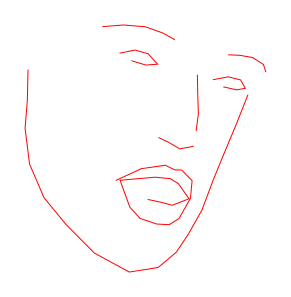

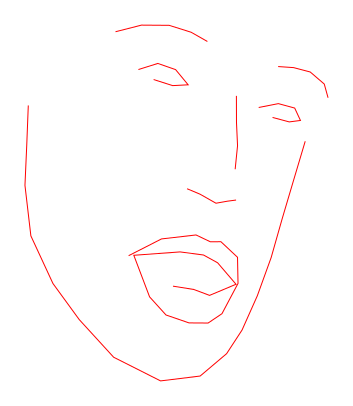

INFO:tensorflow:The size of vector z = 128


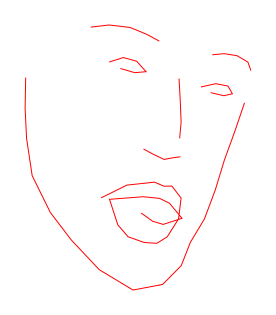

INFO:tensorflow:sample的第 2 张图片


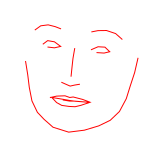

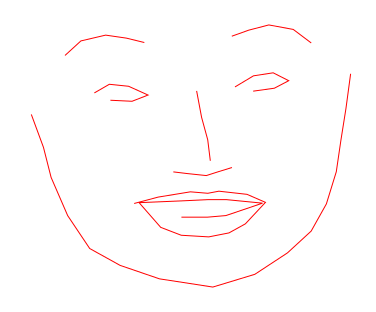

INFO:tensorflow:The size of vector z = 128


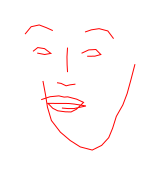

INFO:tensorflow:sample的第 3 张图片


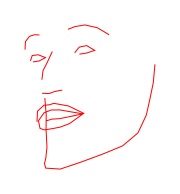

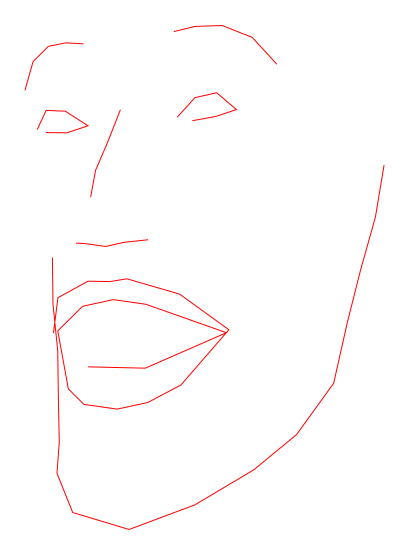

INFO:tensorflow:The size of vector z = 128


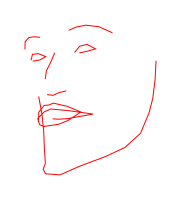

INFO:tensorflow:sample的第 4 张图片


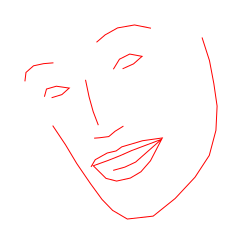

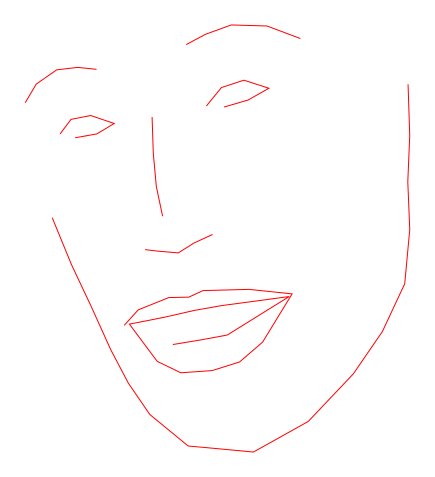

INFO:tensorflow:The size of vector z = 128


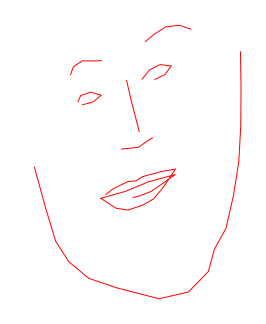

INFO:tensorflow:sample的第 5 张图片


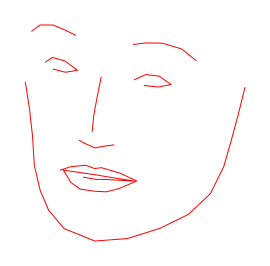

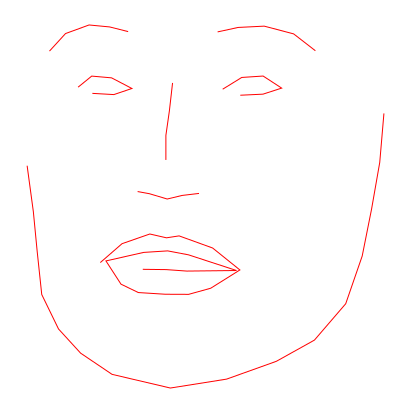

INFO:tensorflow:The size of vector z = 128


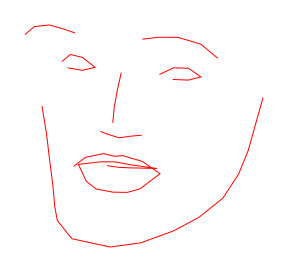

INFO:tensorflow:sample的第 6 张图片


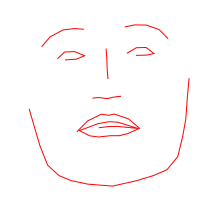

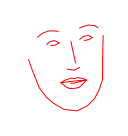

INFO:tensorflow:The size of vector z = 128


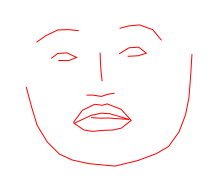

INFO:tensorflow:sample的第 7 张图片


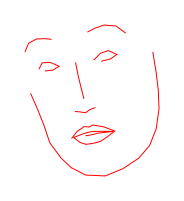

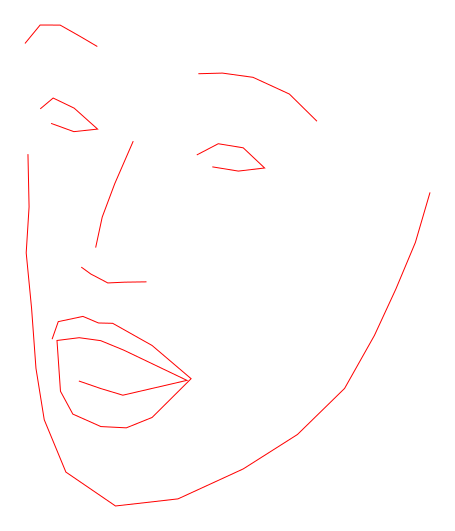

INFO:tensorflow:The size of vector z = 128


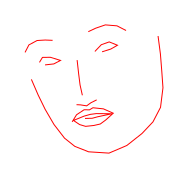

INFO:tensorflow:sample的第 8 张图片


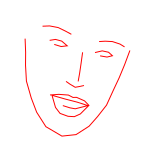

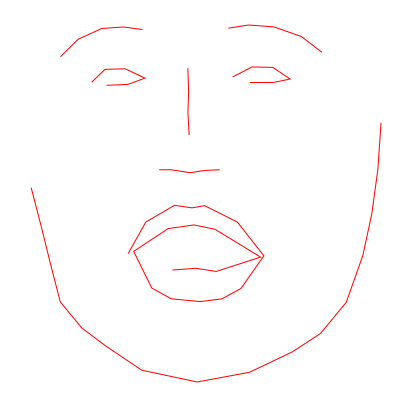

INFO:tensorflow:The size of vector z = 128


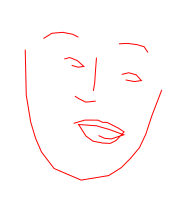

INFO:tensorflow:sample的第 9 张图片


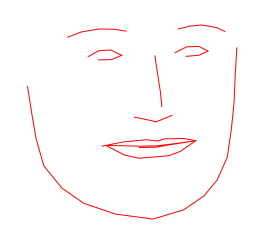

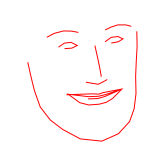

INFO:tensorflow:The size of vector z = 128


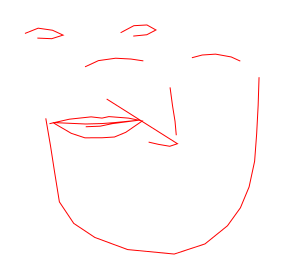

INFO:tensorflow:sample的第 10 张图片


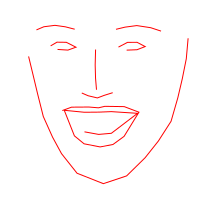

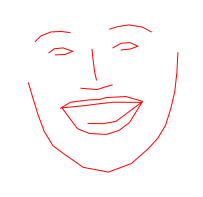

INFO:tensorflow:The size of vector z = 128


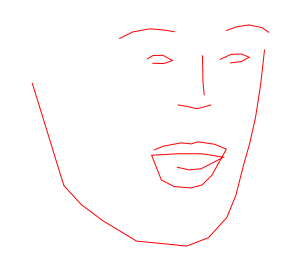

INFO:tensorflow:sample的第 11 张图片


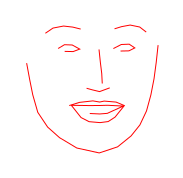

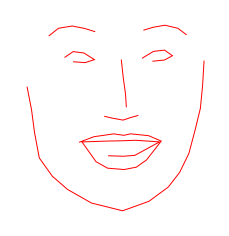

INFO:tensorflow:The size of vector z = 128


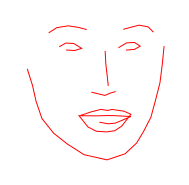

INFO:tensorflow:sample的第 12 张图片


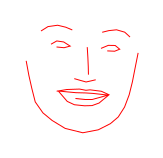

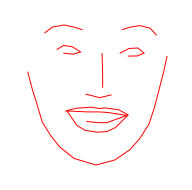

INFO:tensorflow:The size of vector z = 128


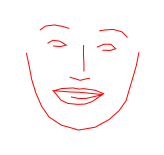

INFO:tensorflow:sample的第 13 张图片


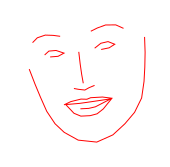

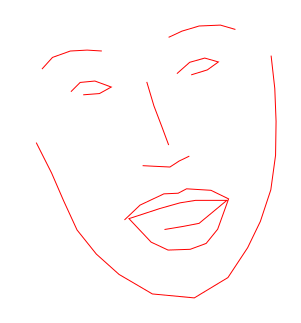

INFO:tensorflow:The size of vector z = 128


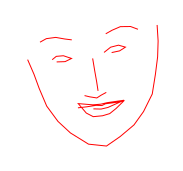

INFO:tensorflow:sample的第 14 张图片


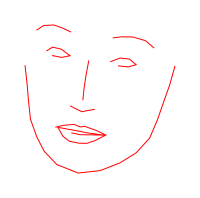

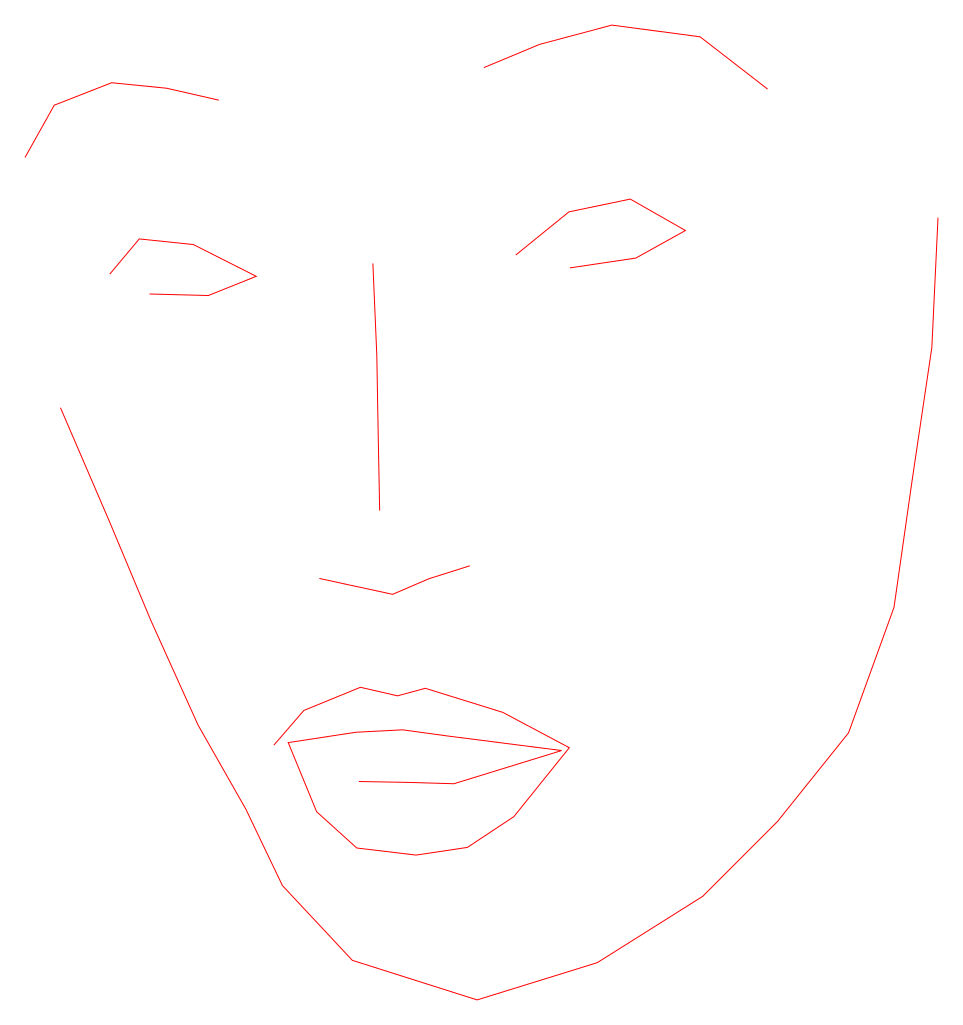

INFO:tensorflow:The size of vector z = 128


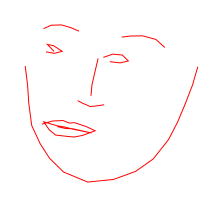

INFO:tensorflow:sample的第 15 张图片


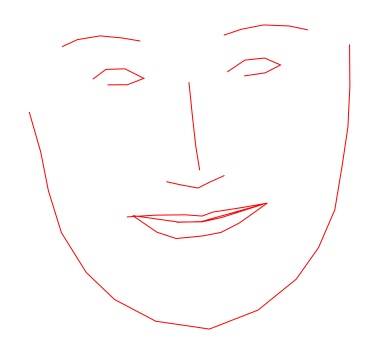

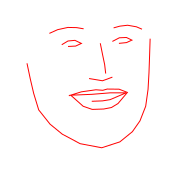

INFO:tensorflow:The size of vector z = 128


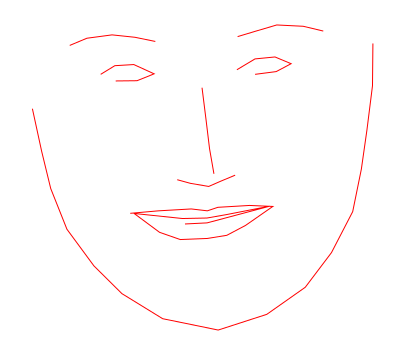

INFO:tensorflow:sample的第 16 张图片


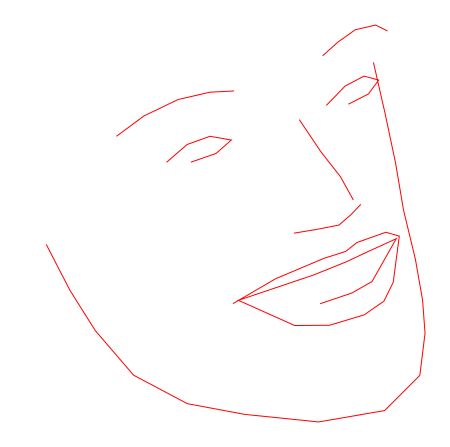

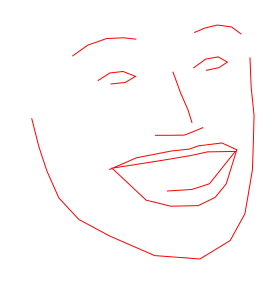

INFO:tensorflow:The size of vector z = 128


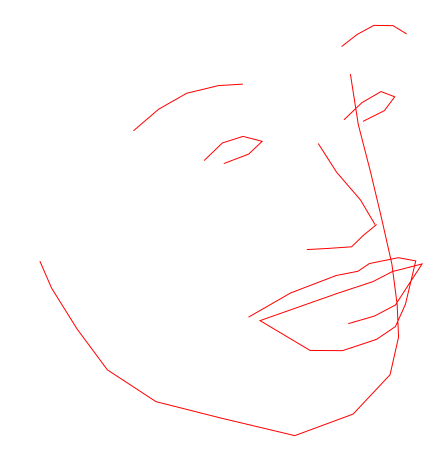

INFO:tensorflow:sample的第 17 张图片


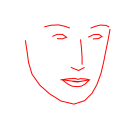

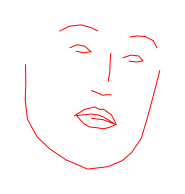

INFO:tensorflow:The size of vector z = 128


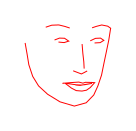

INFO:tensorflow:sample的第 18 张图片


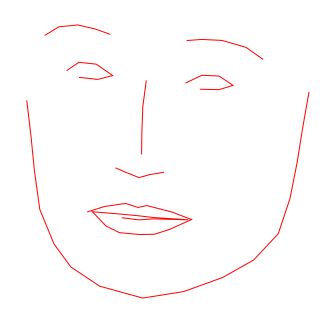

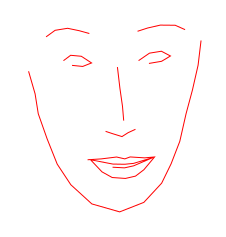

INFO:tensorflow:The size of vector z = 128


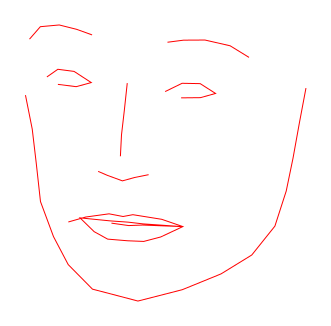

INFO:tensorflow:sample的第 19 张图片


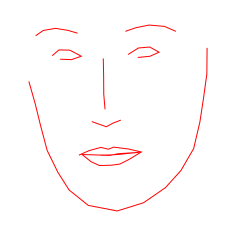

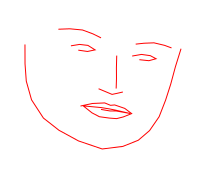

INFO:tensorflow:The size of vector z = 128


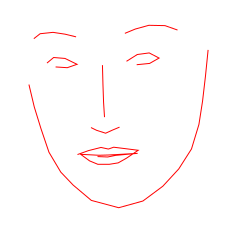

INFO:tensorflow:sample的第 20 张图片


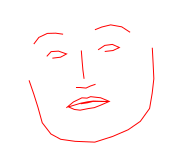

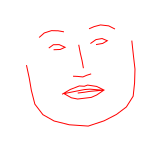

INFO:tensorflow:The size of vector z = 128


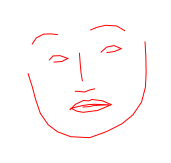

INFO:tensorflow:sample的第 21 张图片


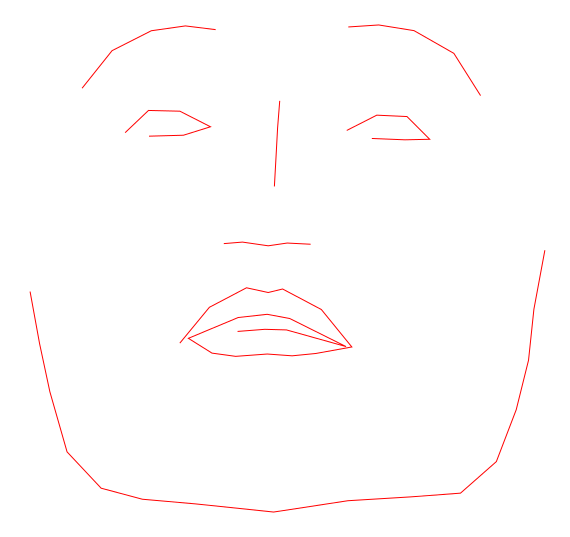

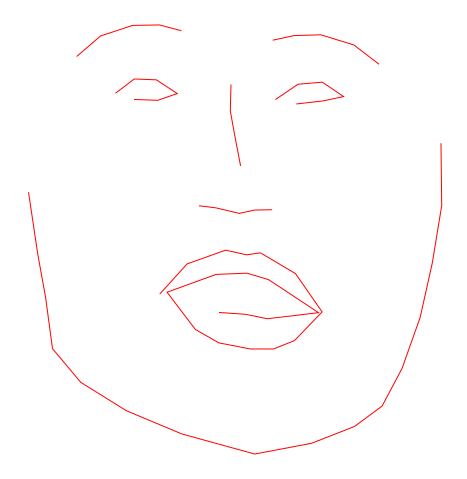

INFO:tensorflow:The size of vector z = 128


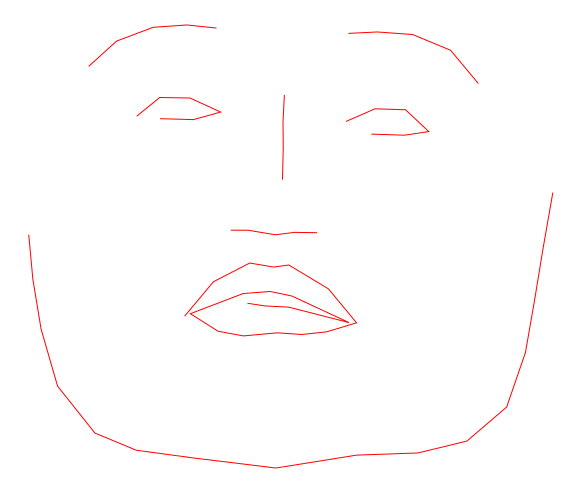

INFO:tensorflow:sample的第 22 张图片


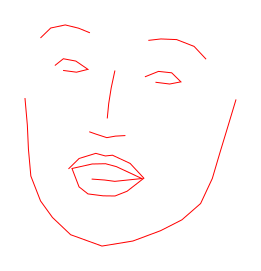

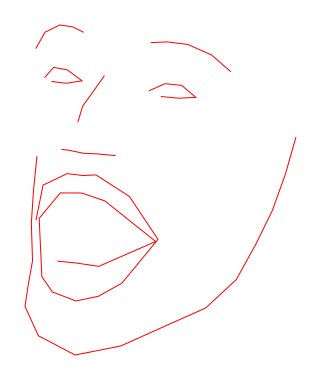

INFO:tensorflow:The size of vector z = 128


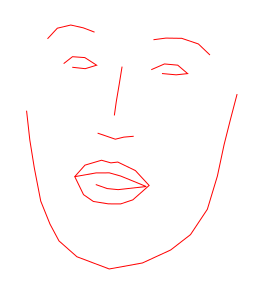

INFO:tensorflow:sample的第 23 张图片


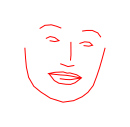

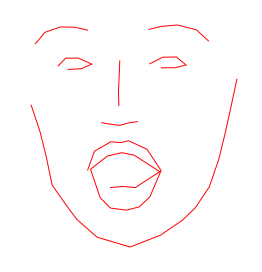

INFO:tensorflow:The size of vector z = 128


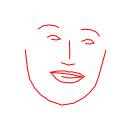

INFO:tensorflow:sample的第 24 张图片


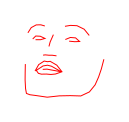

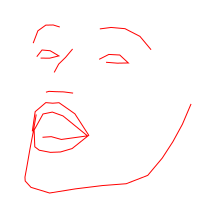

INFO:tensorflow:The size of vector z = 128


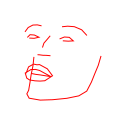

INFO:tensorflow:sample的第 25 张图片


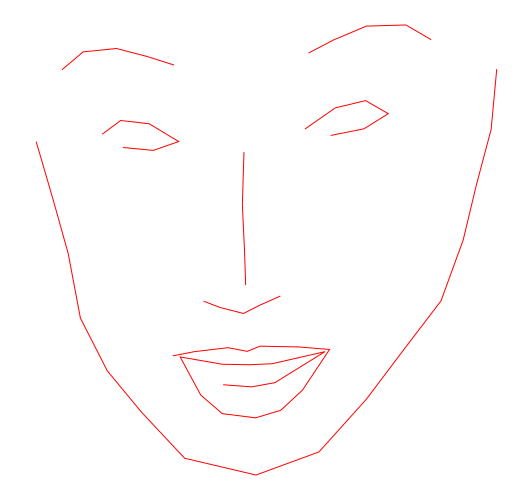

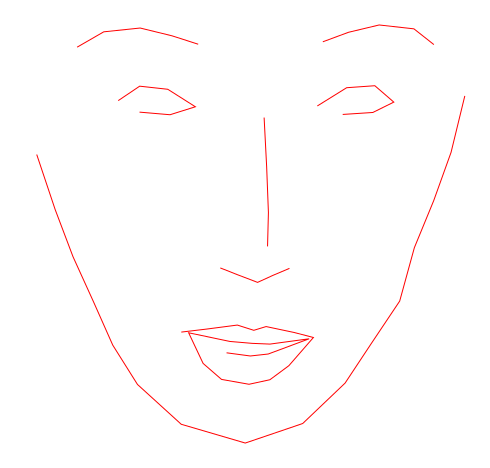

INFO:tensorflow:The size of vector z = 128


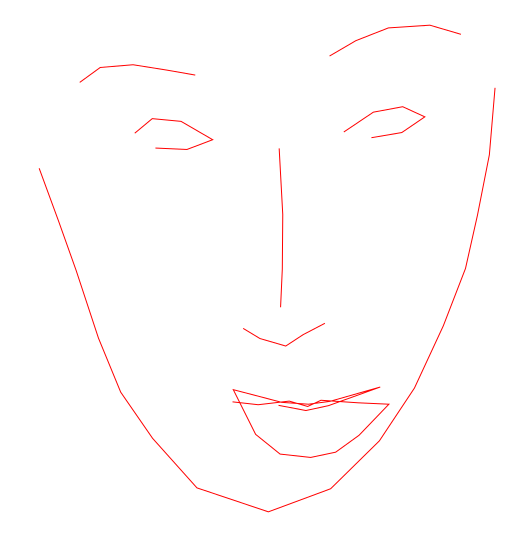

INFO:tensorflow:sample的第 26 张图片


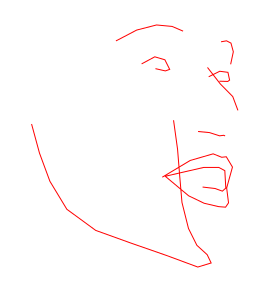

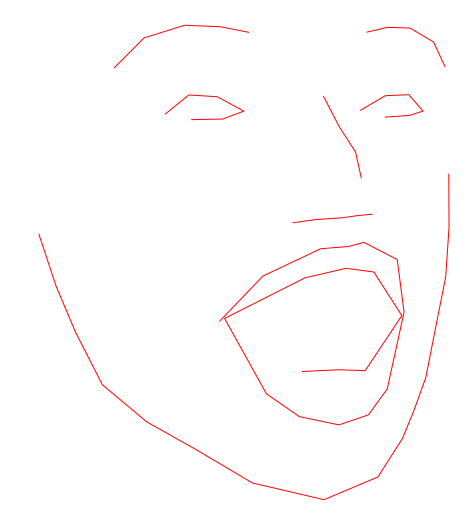

INFO:tensorflow:The size of vector z = 128


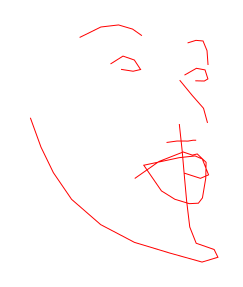

INFO:tensorflow:sample的第 27 张图片


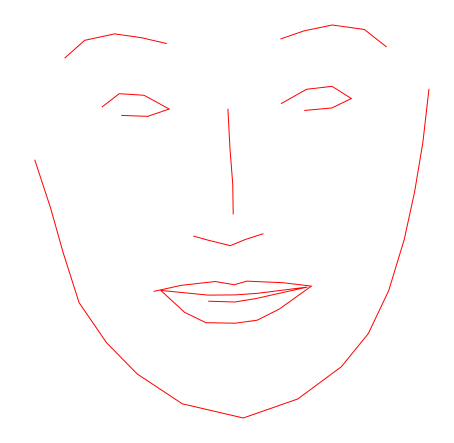

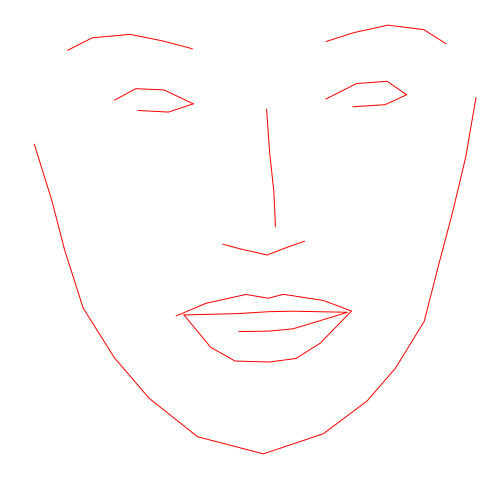

INFO:tensorflow:The size of vector z = 128


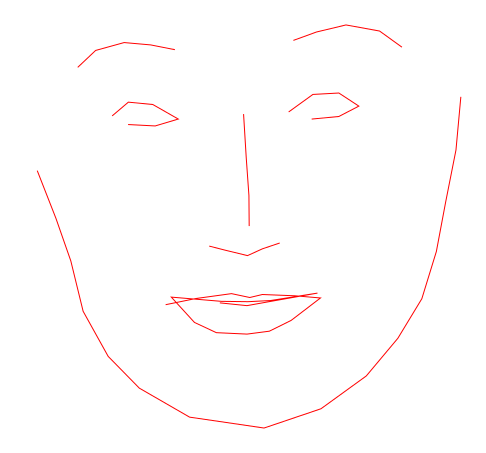

INFO:tensorflow:sample的第 28 张图片


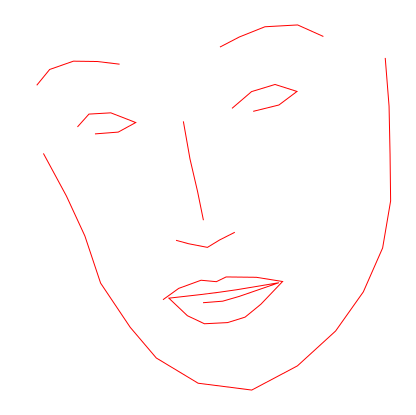

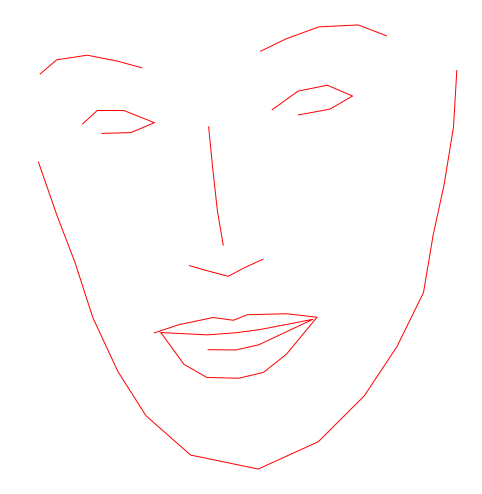

INFO:tensorflow:The size of vector z = 128


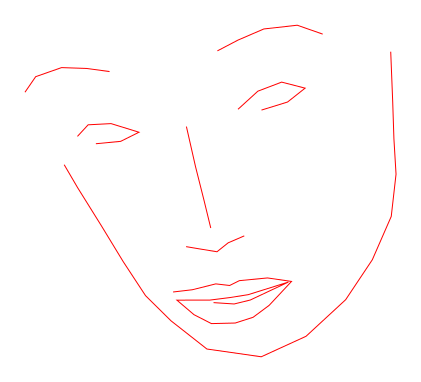

INFO:tensorflow:sample的第 29 张图片


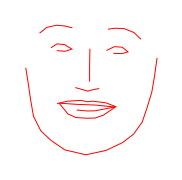

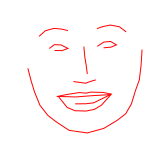

INFO:tensorflow:The size of vector z = 128


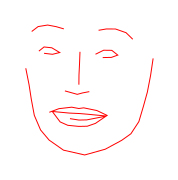

INFO:tensorflow:sample的第 30 张图片


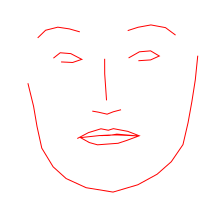

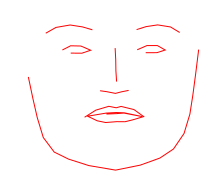

INFO:tensorflow:The size of vector z = 128


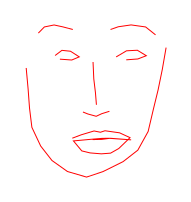

INFO:tensorflow:sample的第 31 张图片


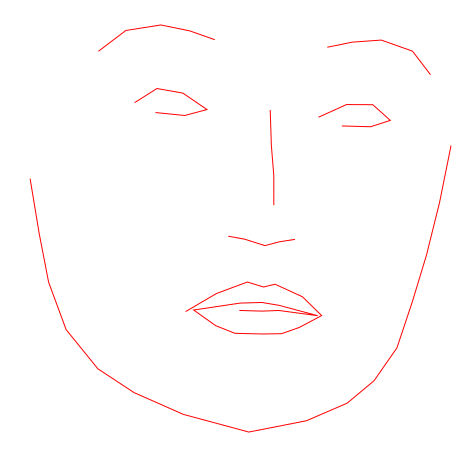

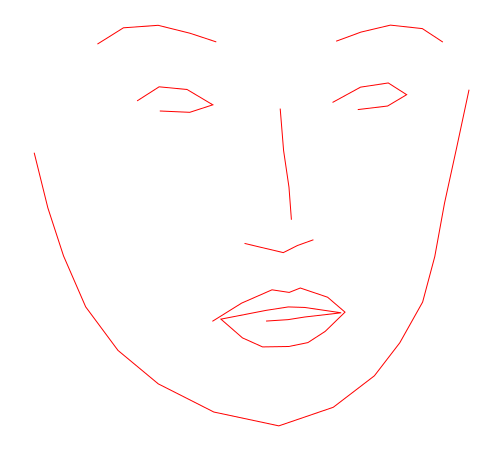

INFO:tensorflow:The size of vector z = 128


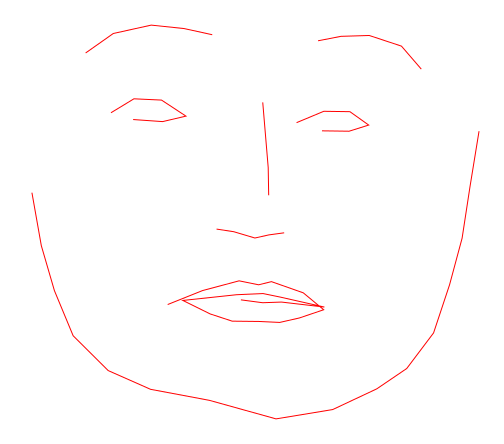

INFO:tensorflow:sample的第 32 张图片


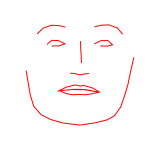

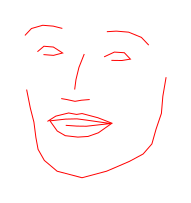

INFO:tensorflow:The size of vector z = 128


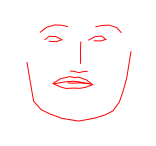

INFO:tensorflow:sample的第 33 张图片


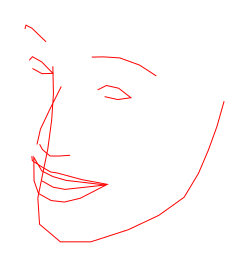

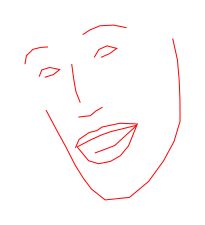

INFO:tensorflow:The size of vector z = 128


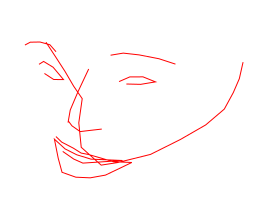

INFO:tensorflow:sample的第 34 张图片


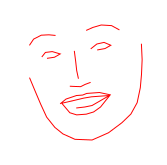

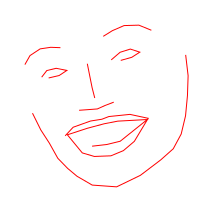

INFO:tensorflow:The size of vector z = 128


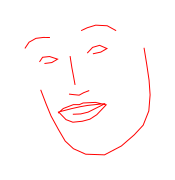

INFO:tensorflow:sample的第 35 张图片


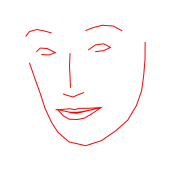

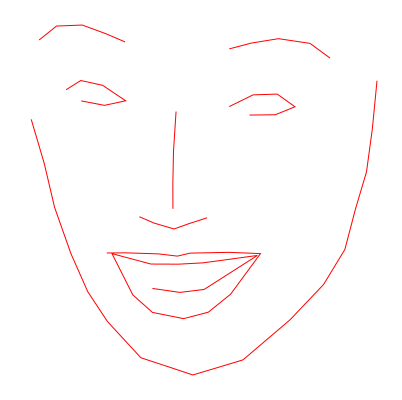

INFO:tensorflow:The size of vector z = 128


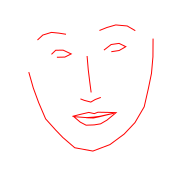

INFO:tensorflow:sample的第 36 张图片


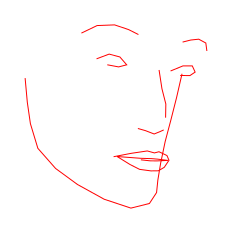

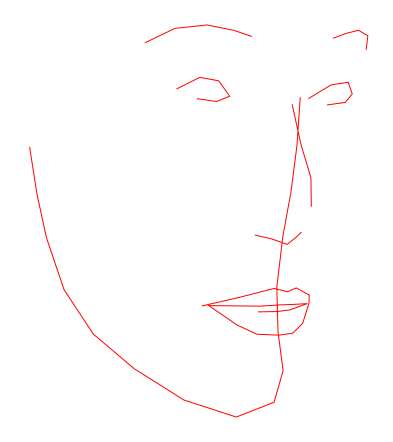

INFO:tensorflow:The size of vector z = 128


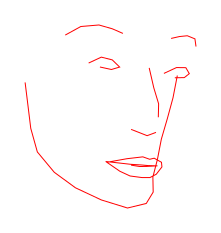

INFO:tensorflow:sample的第 37 张图片


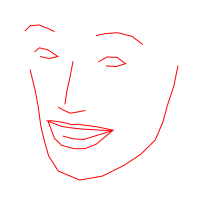

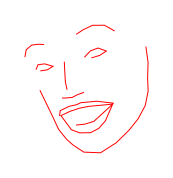

INFO:tensorflow:The size of vector z = 128


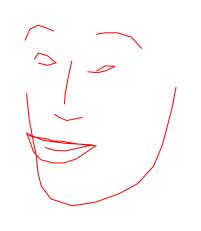

In [2]:
source = np.load('../inputData/source_37.npy')
nosource = np.load('../inputData/source_37_nooffset.npy')
target = np.load('../inputData/target_37.npy')
notarget = np.load('../inputData/target_37_nooffset.npy')
for j in range(37):
    sample_idx = j
    tf.logging.info('sample的第 %i 张图片',sample_idx + 1)
    sources = source[sample_idx] 
    draw_strokes(sources)
    scale_factor = calculate_normalizing_scale_factor(sources)
    sources = normalize(sources,scale_factor)
    sources_people = np.zeros((69, 5), dtype=float)
    sources_people[0,:] = [0, 0, 1, 0, 0]
    sources_people[1:, :] = sources[0:, :]
    
    targets = target[sample_idx]
    draw_strokes(targets)  

    # encoder为隐层变量
    def encode(input_people):
        return sess.run(eval_model.batch_z, feed_dict={
            eval_model.source_input: [input_people], 
            eval_model.sequence_lengths: [68]})[0] 

    z = encode(sources_people)
    tf.logging.info('The size of vector z = %0.0f', z.size)

    #decoder部分
    decoder_input_source_x = sources_people[0:68,:] 
    prev_x = np.zeros((1, 1, 5), dtype=np.float32)
    prev_x[0, 0, 2] = 1  
    prev_state = sess.run(sample_model.initial_state, feed_dict={sample_model.batch_z: [z]})

    #print prev_state.shape
    cartoon = np.zeros((68, 5), dtype=np.float32)
    cartoontry = np.zeros((68, 5), dtype=np.float32)
    mixture_params = []
    greedy = False
    temp = 1.0
    
    for i in range(68): 
        current_x = np.zeros((1, 1, 5), dtype=np.float32)
        current_x[0, 0, :] = decoder_input_source_x[i]  #S1

        feed = {sample_model.decoder_input_source_x: current_x, #S1
                sample_model.decoder_input_target_x: prev_x, #T0
                sample_model.sequence_lengths: [1],
                sample_model.initial_state: prev_state,
                sample_model.batch_z: [z]}
        params = sess.run([
            sample_model.pi, sample_model.mu1, sample_model.mu2, sample_model.sigma1,
            sample_model.sigma2, sample_model.corr,sample_model.pen, sample_model.final_state
        ], feed)

        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen, next_state] = params

        idx = get_pi_idx(random.random(), o_pi[0], 1.0, False)
        idx_eos = get_pi_idx(random.random(), o_pen[0], 1.0, False)
        eos = [0, 0, 0]
        eos[idx_eos] = 1

        next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx],
                                    o_sigma1[0][idx], o_sigma2[0][idx],
                                    o_corr[0][idx], np.sqrt(temp), greedy)

        #cartoon[i, :] = [next_x1 * 2, next_x2 * 2 , eos[0] , eos[1], eos[2]] 
        cartoon[i, 0:2] = [next_x1, next_x2]
        cartoon[i, 2:] =  sources[i][2:].copy()  
        params = [o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0], o_pen[0] ]
        mixture_params.append(params)        
        prev_x = np.zeros((1, 1, 5), dtype=np.float32)  
        prev_x[0][0] = cartoon[i, :] .copy()     
        prev_state = next_state     
        cartoontry[i, 0:2] = [next_x1 * scale_factor, next_x2 * scale_factor]
        cartoontry[i, 2:] =  sources[i,2:].copy()  
    
    draw_strokes(cartoontry)
    
    output1 = '../TPS/test_source_5_2_bs64/'+ str(sample_idx+1) + '.txt'
    with open(output1, 'w') as f:        
        nosources = nosource[sample_idx] 
        sou =  np.zeros((68, 2), dtype=np.float32)
        sou[:, :] = nosources[:, 0:2]
        f.write(str(sou) + '\n')
        
    output2 = '../TPS/test_target_5_2_bs64/'+ str(sample_idx+1) + '.txt'
    with open(output2, 'w') as f:
        notargets = notarget[sample_idx] 
        tar =  np.zeros((68, 2), dtype=np.float32)
        tar[:, :] = notargets[:, 0:2]
        f.write(str(tar) + '\n')
        
    output3 = '../TPS/test_output_5_2_bs64/'+ str(sample_idx+1) + '.txt'
    with open(output3, 'w') as f:
        cart =  np.zeros((68, 2), dtype=np.float32)
        cart[:, :] = cartoontry[:, 0:2]
        nooffset = np.zeros((68, 2), dtype=np.float32)
        nooffset[0] = sou[0]
        for i in range(67):
            x = nooffset[i][0] + cart[i+1][0]
            y = nooffset[i][1] + cart[i+1][1]
            nooffset[i+1] = [x, y]
        f.write(str(nooffset) + '\n')

[1, 393, 500, 3, 1]
178.257264491
179.744979937
179.744979937
0.9999993053359414
-0.00117869743137
0.991723187782


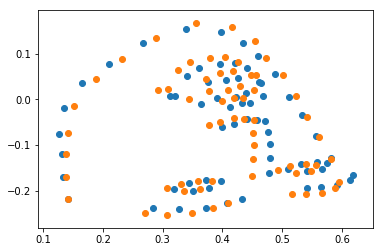

[1, 322, 270, 3, 1]
91.4469941243
74.0955325861
74.0955325861
0.9929000884250131
-0.118951311071
1.23417689208


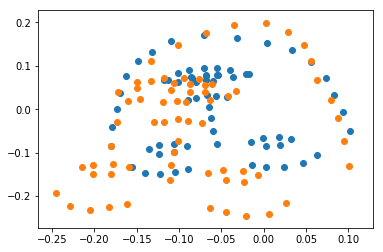

[1, 213, 240, 3, 1]
89.5666869224
96.5349677578
96.5349677578
0.9999033358493409
-0.0139039187771
0.927815992513


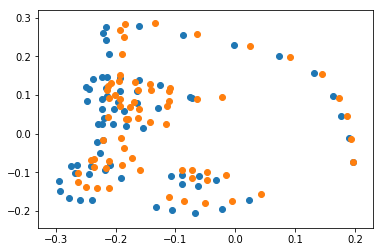

[1, 313, 281, 3, 1]
140.774226379
182.046976252
182.046976252
0.9973845264799748
-0.0722779796225
0.773285166702


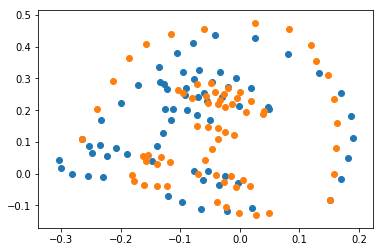

[1, 750, 500, 3, 1]
178.812090396
184.033391162
184.033391162
0.9980497810412666
-0.0624230291117
0.971628514083


/usr/local/lib/python2.7/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


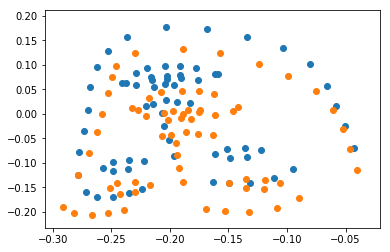

[1, 330, 549, 3, 1]
132.151221381
134.306377827
134.306377827
0.9999935122003151
-0.00360216008505
0.983953431841


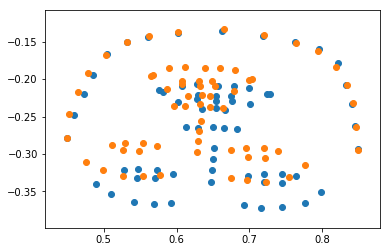

[1, 294, 252, 3, 1]
104.110888712
106.850531739
106.850531739
0.9953216778928548
-0.0966165488752
0.97436004312


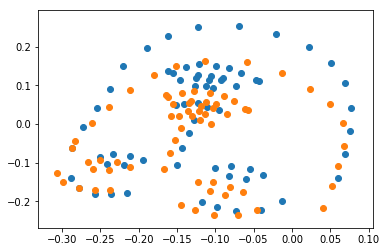

[1, 309, 336, 3, 1]
85.668522242
119.710074568
119.710074568
0.9782442397511427
-0.207456519285
0.715633354594


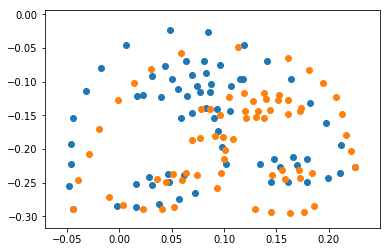

[1, 349, 352, 3, 1]
169.889848275
173.429194621
173.429194621
0.9999689705249069
-0.00787768921435
0.979591980729


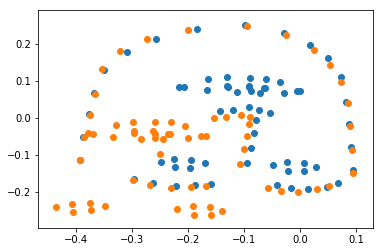

[1, 183, 228, 3, 1]
131.174502095
192.555876631
192.555876631
0.9987928935989648
-0.0491198096109
0.681228246007


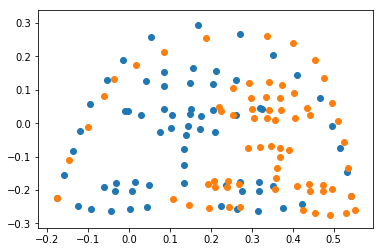

[1, 264, 195, 3, 1]
106.913776774
111.86639719
111.86639719
0.9993990876323826
-0.0346621355309
0.955727362813


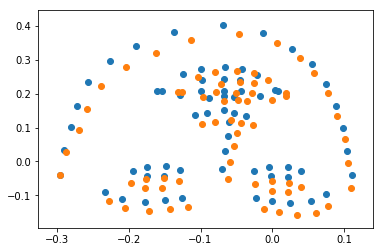

[1, 233, 187, 3, 1]
91.1984015074
91.4151491394
91.4151491394
0.9999779259171099
-0.00664437194286
0.997628974693


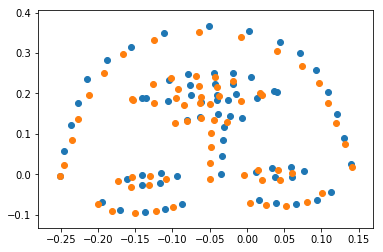

[1, 399, 430, 3, 1]
97.1125514867
107.269147111
107.269147111
0.9999491051251435
-0.0100889622571
0.905316711303


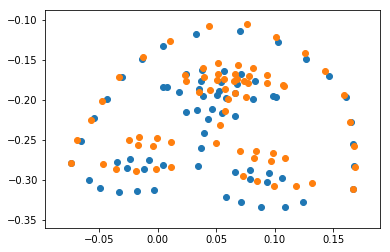

[1, 342, 226, 3, 1]
120.70530439
134.690856977
134.690856977
0.9994983502018874
-0.0316709321572
0.89616553862


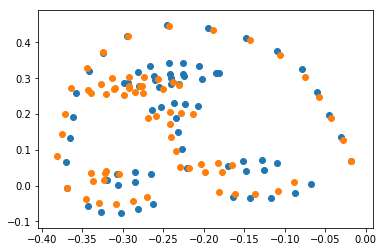

[1, 624, 500, 3, 1]
261.018842112
279.323471199
279.323471199
0.9999079332712077
-0.0135692660561
0.934467987928


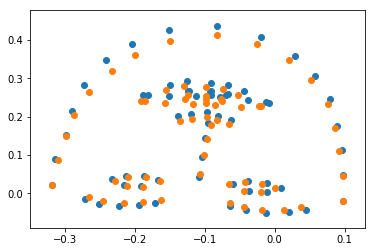

[1, 615, 800, 3, 1]
299.039817583
283.22008613
283.22008613
0.9994209296806209
-0.0340265384123
1.05585667199


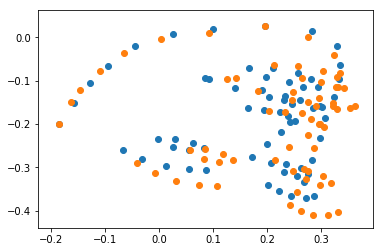

[1, 299, 533, 3, 1]
68.4318562171
68.7930405047
68.7930405047
0.9988464743130454
-0.0480179211587
0.994749697281


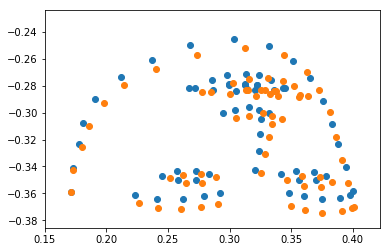

[1, 462, 349, 3, 1]
228.928908861
226.433635766
226.433635766
0.9999241523930119
-0.0123162275522
1.01101988707


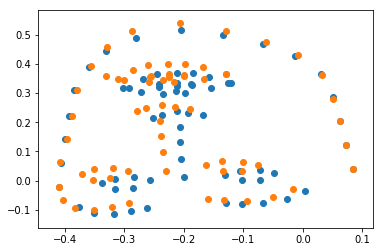

[1, 300, 461, 3, 1]
146.40215776
147.446574011
147.446574011
0.9999503040520732
-0.00996942456546
0.992916646199


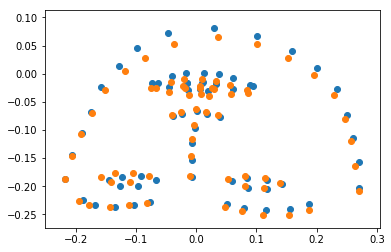

[1, 198, 206, 3, 1]
103.22424675
97.5694364126
97.5694364126
0.9999997733534307
-0.000673270441336
1.05795677976


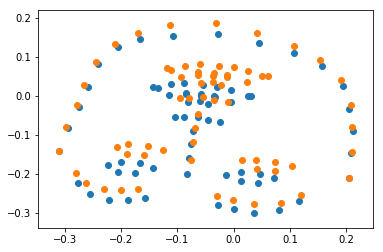

[1, 882, 687, 3, 1]
416.691695082
422.622393515
422.622393515
0.999662621723874
-0.0259738855035
0.985966909175


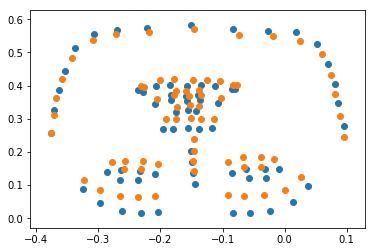

[1, 331, 280, 3, 1]
170.515939275
170.735787064
170.735787064
0.9975717991951883
-0.0696455702143
0.998712350863


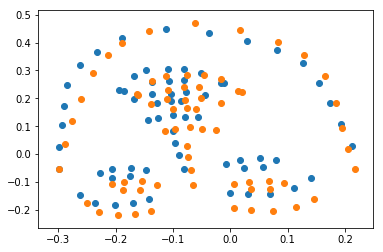

[1, 330, 450, 3, 1]
64.8042952256
65.1959673612
65.1959673612
0.9985463116524903
-0.0539004961499
0.993992387085


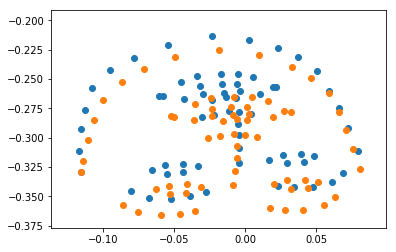

[1, 173, 171, 3, 1]
63.1580030527
53.5010609744
53.5010609744
0.997299106529529
-0.0734472063145
1.1805000107


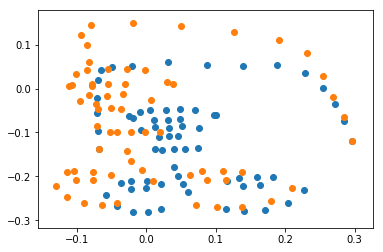

[1, 900, 567, 3, 1]
377.985821493
377.184035817
377.184035817
0.9998041613611309
-0.0197898692508
1.00212571477


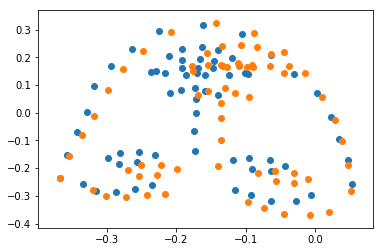

[1, 457, 469, 3, 1]
121.13442059
127.07111152
127.07111152
0.9991204274756484
-0.0419329393303
0.953280561892


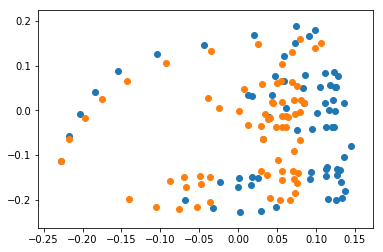

[1, 841, 596, 3, 1]
323.733940239
349.573925926
349.573925926
0.999999593463255
-0.000901705786151
0.926081484427


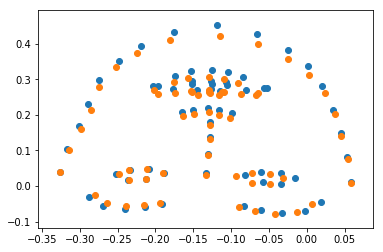

[1, 883, 555, 3, 1]
291.680502648
280.426697753
280.426697753
0.9935943116273944
-0.113005946311
1.04013100388


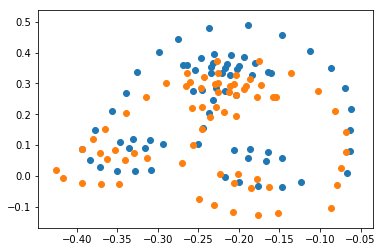

[1, 171, 311, 3, 1]
106.32206196
103.218040415
103.218040415
0.9999996079523805
-0.000885491437172
1.03007247117


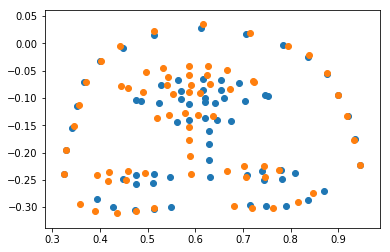

[1, 313, 259, 3, 1]
138.452482259
113.342759163
113.342759163
0.9997106002632657
-0.0240565109952
1.22153795515


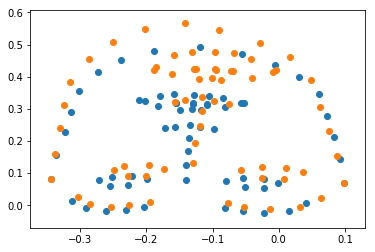

[1, 889, 581, 3, 1]
342.090437147
364.048953611
364.048953611
0.995358758087863
-0.0962337918706
0.939682517294


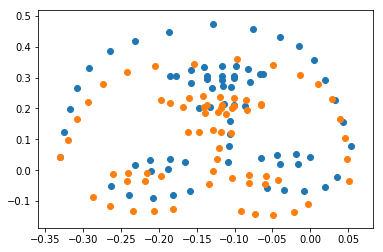

[1, 152, 109, 3, 1]
87.4676195667
85.0851595462
85.0851595462
0.999980897207245
-0.00618103717779
1.02800088797


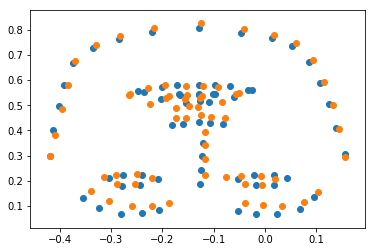

[1, 278, 266, 3, 1]
144.875889773
167.505503641
167.505503641
0.9843933118068728
-0.175982407274
0.864902266635


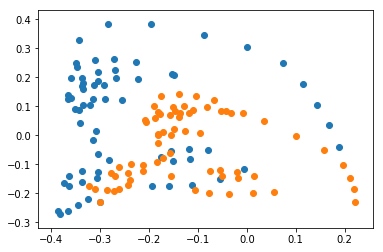

[1, 250, 350, 3, 1]
94.9708322822
89.7614378375
89.7614378375
0.9964044471834578
-0.0847241266289
1.05803599597


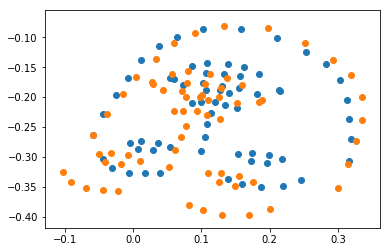

[1, 222, 169, 3, 1]
96.679177082
103.66753594
103.66753594
0.9952088354663972
-0.0977720502476
0.932588743483


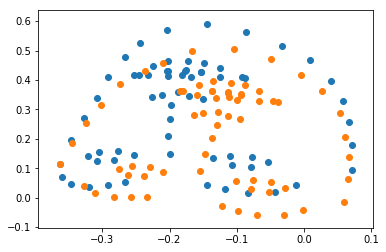

[1, 367, 246, 3, 1]
126.90072861
122.807736867
122.807736867
0.9999505791625539
-0.00994179221635
1.03332845184


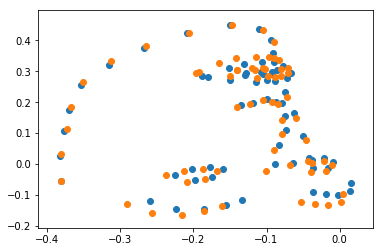

[1, 393, 300, 3, 1]
121.007473297
121.114663517
121.114663517
0.9998516665291284
-0.0172233834924
0.999114969101


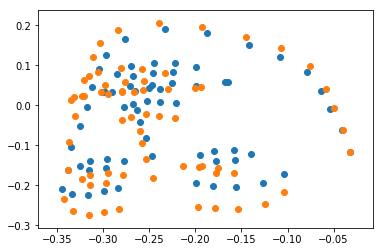

In [3]:
for k in range(37): 
    imgpath = '../data/test_source/'+ 'p (' + str(k+1) + ').jpg'
    img = np.array(Image.open(imgpath))
    points = 68
    out_size = list(img.shape)
    weight = out_size[0] 
    height = out_size[1]
    shape = [1] + out_size + [1]
    print shape
    x0 = weight / 2
    y0 = height / 2
    sourcepath = '../TPS/test_source_5_2_bs64/' + str(k+1) + '.txt'
    lines = open(sourcepath,'r').readlines()
    s_ =[]
    for i,f in enumerate(lines):
        nums = re.compile(r'[1-9]\d*\.\d*|0\.\d*[1-9]|[1-9]\d*|0\.\d*').findall(f)
        if len(nums) == 2:
                nums = [float(numb) for numb in nums]
                s_.append(nums)
    s_ = np.asarray(s_, dtype=np.float32)
    #print s_
    targetpath = '../TPS/test_output_5_2_bs64/' + str(k+1) + '.txt'
    lines = open(targetpath,'r').readlines()
    t_ =[]
    for i,f in enumerate(lines):
        nums = re.compile(r'[1-9]\d*\.\d*|0\.\d*[1-9]|[1-9]\d*|0\.\d*').findall(f)
        if len(nums) == 2:
                nums = [float(numb) for numb in nums]
                t_.append(nums)
    t_ = np.asarray(t_, dtype=np.float32)
    #print t_
    t = start(s_,t_)
    #print t
    sour_dis = point_dist(s_)
    tar_dis = point_dist(t)
    tar_dis1 = point_dist(t_)
    print(sour_dis)
    print(tar_dis)
    print(tar_dis1)

    s0 = zeropoint(s_)
    t0 = zeropoint(t)
    #计算两个向量夹角的sin以及cos
    cos = ((s0[16][0]*t0[16][0]) + (s0[16][1]*t0[16][1])) / (sour_dis * tar_dis)
    print(cos)
    sin = - math.sqrt(1-cos*cos)
    print(sin)

    #旋转伸缩
    #[x*cosA-y*sinA  x*sinA+y*cosA]
    r = sour_dis / tar_dis
    print(r)
    ab_new = np.zeros((68, 2), dtype=np.float32)
    ab_co = t0.copy()
    for i in range(68):
        ab_new[i][0] = (ab_co[i][0]*cos - ab_co[i][1]*sin) * r
        ab_new[i][1] = (ab_co[i][0]*sin + ab_co[i][1]*cos) * r
    #print(ab_new)
    #print(s0)
    source = reback(s0,s_)
    target = reback(ab_new,s_)

    for i in range(points):
        source[i,0] = (source[i][0] - x0 ) / weight
        source[i,1] = (source[i][1] - y0 ) / height
    plt.scatter(source[:,0], source[:,1])
    #plt.show()
    for i in range(points):
        target[i,0] = (target[i][0] - x0 ) / weight 
        target[i,1] = (target[i][1] - y0 ) / height  
    plt.scatter(target[:,0], target[:,1])
    plt.show()

    s = tf.constant(source.reshape([1, points, 2]), dtype=tf.float32)  #将s_ reshape成tf tensor {batch, num_points, 2}
    t = tf.constant(target.reshape([1, points, 2]), dtype=tf.float32)  #将t_ reshape成tf tensor
    t_img = tf.constant(img.reshape(shape), dtype=tf.float32)
    t_img = stn(t_img, t, s, out_size)
    sess.run(tf.global_variables_initializer())
    img1 = sess.run(t_img)
    resultpath = 'resultimage_5_2_bs64/'+ str(k+1) + '.jpg'
    Image.fromarray(np.uint8(img1.reshape(out_size))).save(resultpath)